In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Embedding, TimeDistributed, LeakyReLU
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot
from pickle import load

### load data

In [2]:
# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)


 EPOCH-indicates the number of passes of the entire training dataset the machine learning algorithm has completed.

In [3]:
# Parameters
LR = 0.0001
BATCH_SIZE = 128
N_EPOCH = 50

input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]


### 1. GRU model:
**Gated Recurrent Unit (GRU)** -
- GRUs are very similar to Long Short Term Memory(LSTM). Just like LSTM, GRU uses gates to control the flow of information.
- GRU have two gates the update gate and reset gate for filtering out what information should remain and what should be disposed of.

In [4]:
def basic_GRU(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=128, return_sequences = True, input_shape=(input_dim, feature_size)))  # 256, return_sequences = True
    # model.add(GRU(units=256, recurrent_dropout = 0.2)) #, return_sequences = True
    model.add(GRU(units=64, input_shape=(input_dim, feature_size)))
    #model.add(Dense(128))
    model.add(Dense(32))
    # model.add(Dense(32))
    model.add(Dense(units=output_dim))
    model.compile(optimizer=Adam(lr=LR), loss='mse')
    history = model.fit(X_train, y_train, epochs=N_EPOCH, batch_size=BATCH_SIZE, validation_data=(X_test, y_test),
                        verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()

    return model


C:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
14/14 - 15s - loss: 0.4275 - val_loss: 0.0594 - 15s/epoch - 1s/step
Epoch 2/50
14/14 - 0s - loss: 0.0222 - val_loss: 0.0324 - 360ms/epoch - 26ms/step
Epoch 3/50
14/14 - 0s - loss: 0.0226 - val_loss: 0.0367 - 309ms/epoch - 22ms/step
Epoch 4/50
14/14 - 0s - loss: 0.0118 - val_loss: 0.0458 - 410ms/epoch - 29ms/step
Epoch 5/50
14/14 - 0s - loss: 0.0065 - val_loss: 0.0486 - 301ms/epoch - 21ms/step
Epoch 6/50
14/14 - 0s - loss: 0.0053 - val_loss: 0.0483 - 358ms/epoch - 26ms/step
Epoch 7/50
14/14 - 0s - loss: 0.0047 - val_loss: 0.0481 - 333ms/epoch - 24ms/step
Epoch 8/50
14/14 - 0s - loss: 0.0041 - val_loss: 0.0470 - 363ms/epoch - 26ms/step
Epoch 9/50
14/14 - 0s - loss: 0.0036 - val_loss: 0.0449 - 342ms/epoch - 24ms/step
Epoch 10/50
14/14 - 0s - loss: 0.0032 - val_loss: 0.0428 - 341ms/epoch - 24ms/step
Epoch 11/50
14/14 - 0s - loss: 0.0028 - val_loss: 0.0407 - 335ms/epoch - 24ms/step
Epoch 12/50
14/14 - 0s - loss: 0.0024 - val_loss: 0.0387 - 358ms/epoch - 26ms/step
Epoch 13/50
14/1

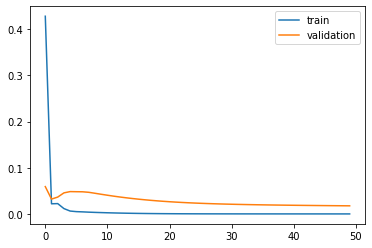

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 128)            63744     
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 103,105
Trainable params: 103,105
Non-trainable params: 0
_________________________________________________________________
None
0.13344073808310875


In [5]:
model = basic_GRU(input_dim, output_dim, feature_size)
print(model.summary())
model.save('GRU_30to3.h5')

yhat = model.predict(X_test, verbose=0)
# print(yhat)

rmse = sqrt(mean_squared_error(y_test, yhat))
print(rmse)


### train data

In [6]:

def plot_traindataset_result(X_train, y_train):
    train_yhat = model.predict(X_train, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb')) #convert python object to the byte code
    train_predict_index = np.load("index_train.npy", allow_pickle=True) #file save in NumPy file format in array form.

    rescaled_real_y = y_scaler.inverse_transform(y_train)
    rescaled_predicted_y = y_scaler.inverse_transform(train_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=train_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=train_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Train", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Train RMSE -- ', RMSE)

    return RMSE


### Test data

In [7]:
# %% --------------------------------------- Plot the result  -----------------------------------------------------------------
def plot_testdataset_result(X_test, y_test):

    test_yhat = model.predict(X_test, verbose=0)
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("index_test.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    Input_Before = '2020-01-01'
    predict_result = predict_result.loc[predict_result.index < Input_Before]
    real_price = real_price.loc[real_price.index < Input_Before]

    print(predict_result.tail(10))

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE -- ', RMSE)

    return RMSE



In [8]:
def plot_testdataset_with_result(X_test, y_test):


    test_yhat = model.predict(X_test, 1, verbose=0)

    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = np.load("yc_train.npy", allow_pickle=True)

    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(test_yhat)

    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"],
                               index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Testing with 2020", fontsize=20)
    plt.show()

    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    #print('-- Test RMSE with 2020 -- ', RMSE)

    return RMSE


**Root-mean-square deviation**

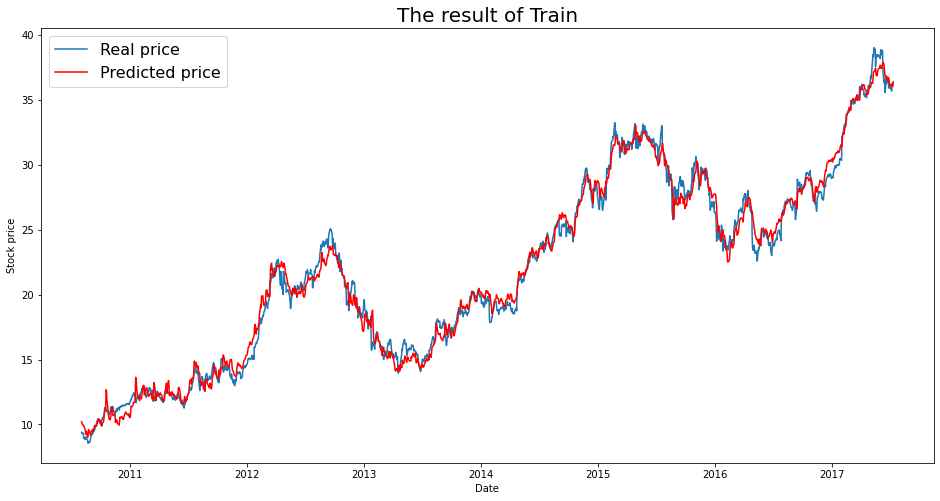

In [9]:
train_RMSE = plot_traindataset_result(X_train, y_train)

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              NaN              NaN              NaN   
2019-12-23              NaN              NaN              NaN   
2019-12-24              NaN              NaN              NaN   
2019-12-26              NaN              NaN              NaN   
2019-12-27              NaN              NaN              NaN   
2019-12-30              NaN              NaN              NaN   
2019-12-31              NaN              NaN              NaN   

            predicted_price  predicted_price  predicted_price  \
2019-12-17              NaN              NaN              NaN   
2019-12-18              NaN              NaN              NaN   
2019-12-19              NaN              NaN              NaN   
2019-12-20              

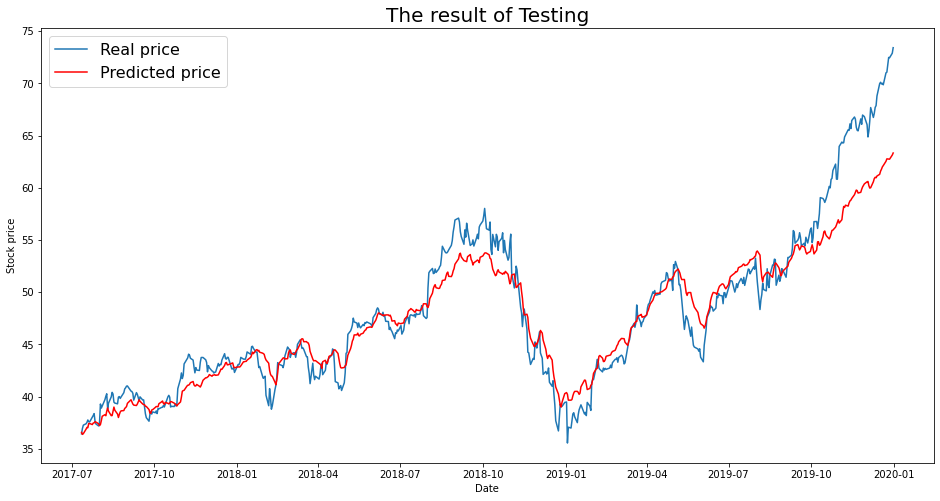

----- Test_RMSE_LSTM ----- 2.554107539438241


In [10]:
test_RMSE = plot_testdataset_result(X_test, y_test)
print("----- Test_RMSE_LSTM -----", test_RMSE)